In [1]:
from __future__ import division
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from timeit import default_timer
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset, Subset
import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import os
import random
import argparse
from tqdm import tqdm
import librosa
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from torchsummary import summary
from scipy.stats import mode
from sklearn.model_selection import KFold
from torchvision.models import densenet121
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import recall_score


os.environ['CUDA_VISIBLE_DEVICES'] ='0'

In [2]:
EPOCHS = 20
SEED = 2024
BATCH_SIZE = 32
TEST_SPLIT_RATIO = 0.25
N_FFT = 256
HOP_LEN = 256 // 6
AUGM = False # Augmentation
# Creating the results directory
if not os.path.exists('results'):
    os.makedirs('results')
RESULTS_FILENAME = "./results/inrun_results" # _x.csv
VALID_RESULTS_FILENAME = "./results/valid_results" # _x.csv
TRAIN_RESULTS_FILENAME = "./results/train_results" # _x.csv
BEST_MODEL_FILENAME = "./results/best-model" # _x.pt
EVAL_FREQ=4
NUM_SIMS = 5

In [3]:
TRAIN_DATASET = "../data/train_whales.csv"
TEST_DATASET = "../data/test_whales.csv"

In [4]:
# Fixing the seeds
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

print(f"Cuda is available: {torch.cuda.is_available()}")
dev_names = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]
print(f"Device: {dev_names}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Cuda is available: True
Device: ['NVIDIA GeForce RTX 3090']


In [5]:
target_names = ["no-whale","whale"]
target_names_dict = {target_names[i]: i for i in range(len(target_names))}

# Loading the data

In [6]:
t_s = default_timer()
data_train = pd.read_csv(TRAIN_DATASET,sep=",")
columns = data_train.columns
data_train[columns[-1]]=data_train[columns[-1]].replace(target_names_dict)
data_train = data_train.values
data_train_labels = data_train[:,-1].reshape(-1)
data_train_labels = data_train_labels.astype(int)
data_train = data_train[:,:-1]

data_test = pd.read_csv(TEST_DATASET,sep=",")
data_test[columns[-1]]=data_test[columns[-1]].replace(target_names_dict)
data_test = data_test.values
data_test_labels = data_test[:,-1].reshape(-1)
data_test_labels = data_test_labels.astype(int)
data_test = data_test[:,:-1]
t_e = default_timer()

print(f"Data loading - Elapsed time: {t_e-t_s:.2f}s")

Data loading - Elapsed time: 8.87s


In [7]:
X_test, y_test = data_test, data_test_labels

In [8]:
data_train.shape, data_test.shape

((10316, 4000), (2580, 4000))

In [9]:
def random_data_shift(data, u=1.0):
    if np.random.random() < u:
        shift = int(round(np.random.uniform(-len(data)*0.25, len(data)*0.25)))
        data = np.roll(data, shift)
    return data

class AugmentedSTFTDataset(Dataset):
    def __init__(self, inputs, targets, n_fft, hop_length, augment=False):
        self.inputs = inputs
        self.targets = targets
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.augment = augment

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
        sample = self.inputs[idx]
        #print(sample.shape)
        if self.augment:
            sample = random_data_shift(sample)
            #print("OK")
        #print(sample.shape)
        data = librosa.stft(sample, n_fft=self.n_fft, hop_length=self.hop_length)
        data = librosa.amplitude_to_db(np.abs(data), ref=np.max)
        data = np.flipud(data)  # Flip vertically
        data = data.copy()  # Itt készítünk egy másolatot a tömbről, hogy megoldjuk a negatív stride problémát
        data = np.expand_dims(data, axis=-1)  # Add channel dimension
        data = np.transpose(data, (2, 0, 1))  # Reorder dimensions to match PyTorch expectations
        return torch.FloatTensor(data), torch.LongTensor([self.targets[idx]])

# Data loader
def create_dataloader(inputs, targets, batch_size, n_fft, hop_length, shuffle=True, augment=False):
    dataset = AugmentedSTFTDataset(inputs, targets, n_fft, hop_length, augment=augment)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Model

In [11]:
class Densenet121(nn.Module):
    def __init__(self):
        super().__init__()
        self.densenet121 = densenet121().features
        self.densenet121.conv0 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.classifier = torch.nn.Linear(1024, 1)
        
    def forward(self, x):
        out = self.densenet121.forward(x)
        out = torch.nn.functional.avg_pool2d(out, kernel_size = out.shape[2:], stride= out.shape[2:], padding=0, count_include_pad = False)
        out = self.classifier(out.view(out.shape[0], -1))
        return out

In [12]:
model = Densenet121()
model.to(device)

Densenet121(
  (densenet121): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

# Utilities

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [14]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0.0
    epoch_acc = 0.0

    model.eval()
    number_of_elements = 0
    
    correct_pred = torch.zeros(2)
    total_pred = torch.zeros(2)


    with torch.no_grad():
        
        y_true = []
        y_pred = []
        for x, y in iterator:

            x = x.to(device)
            y = y.float().to(device).view(-1,1)
            
            batch_size = x.shape[0]
            number_of_elements += batch_size
            
            pred = model(x).view(-1,1)
            loss = criterion(pred, y)
            
            top_pred = (torch.sigmoid(pred) > 0.5).int()
            acc = top_pred.eq(y.int().view_as(top_pred)).sum()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            y_true.append(y.int().cpu().numpy())
            y_pred.append(top_pred.cpu().numpy())
            
        y_true_a = np.concatenate(y_true, axis=0)
        y_pred_a = np.concatenate(y_pred, axis=0)
                        
        #balanced_acc = balanced_accuracy_score(y_true_a, y_pred_a)
        acc = accuracy_score(y_true_a, y_pred_a)

    return epoch_loss / number_of_elements, acc

# Evaluation of the metamodels

In [15]:
criterion = torch.nn.BCEWithLogitsLoss(reduction="sum").to(device)


In [16]:
fold_results = np.zeros((len(data_test_labels), 5))  # 5 model predikciójának tárolására
fold_results_probs = np.zeros((len(data_test_labels), 5),dtype=float)  # 5 model predikciójának tárolására
for sim_num, (train_index, valid_index) in enumerate(kf.split(data_train)):
    
    X_train, X_valid = data_train[train_index], data_train[valid_index]
    y_train, y_valid = data_train_labels[train_index], data_train_labels[valid_index]
    X_test, y_test = data_test, data_test_labels
    
    
    
    train_loader = create_dataloader(X_train, y_train, batch_size=BATCH_SIZE, n_fft = N_FFT, hop_length = HOP_LEN, shuffle=True, augment=AUGM)
    valid_loader = create_dataloader(X_valid, y_valid, batch_size=BATCH_SIZE, n_fft = N_FFT, hop_length = HOP_LEN, shuffle=False, augment=False)
    test_loader = create_dataloader(X_test, y_test, batch_size=BATCH_SIZE, n_fft = N_FFT, hop_length = HOP_LEN, shuffle=False, augment=False)
    
    EVAL_FREQ_ = len(train_loader)//EVAL_FREQ + 1
    
    model = Densenet121()
    state_dict = torch.load(f"{BEST_MODEL_FILENAME}_{sim_num}.pt")
    model.load_state_dict(state_dict)
    model.to(device)
    train_loss, train_acc = evaluate(model, train_loader, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    print(f'Model {sim_num} | Train Loss: {train_loss:.3f} -  Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} - Valid Acc: {valid_acc*100:.2f}% | Test Loss: {test_loss:.3f} - Test Acc: {test_acc*100:.2f}% \t')
    
    model.eval()
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            #print("ok")
            output = model(data.to(device))
            #print("ok")
            probs = torch.sigmoid(output)
            preds =  (probs > 0.5).int().cpu().numpy()
            #print("ok")
            probs = probs.cpu().numpy()
            fold_results[i*BATCH_SIZE:i*BATCH_SIZE+len(preds), sim_num] = preds.reshape(-1)
            fold_results_probs[i*BATCH_SIZE:i*BATCH_SIZE+len(preds), sim_num] = probs.reshape(-1)
            #print("ok")

Model 0 | Train Loss: 0.126 -  Train Acc: 95.10% | Valid Loss: 0.163 - Valid Acc: 94.09% | Test Loss: 0.209 - Test Acc: 92.29% 	
Model 1 | Train Loss: 0.102 -  Train Acc: 95.67% | Valid Loss: 0.233 - Valid Acc: 92.87% | Test Loss: 0.228 - Test Acc: 92.75% 	
Model 2 | Train Loss: 0.149 -  Train Acc: 93.49% | Valid Loss: 0.206 - Valid Acc: 92.39% | Test Loss: 0.195 - Test Acc: 92.09% 	
Model 3 | Train Loss: 0.156 -  Train Acc: 93.76% | Valid Loss: 0.202 - Valid Acc: 92.49% | Test Loss: 0.205 - Test Acc: 92.05% 	
Model 4 | Train Loss: 0.139 -  Train Acc: 94.84% | Valid Loss: 0.188 - Valid Acc: 92.24% | Test Loss: 0.189 - Test Acc: 92.29% 	


In [17]:
fold_results

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.]])

In [18]:
final_predictions_test = mode(fold_results, axis=1)[0].flatten()
final_predictions_test_2 = np.round(np.mean(fold_results_probs, axis=1))

In [19]:
accuracy = np.mean(final_predictions_test == data_test_labels)
accuracy_2 = np.mean(final_predictions_test_2 == data_test_labels)
print(f'Test accuracy with majority voting: {accuracy*100:.2f}%')
print(f'Test accuracy with average voting: {accuracy_2*100:.2f}%')

Test accuracy with majority voting: 93.06%
Test accuracy with average voting: 93.06%


In [20]:
print(f"Test recall with majority voting: {recall_score(data_test_labels,final_predictions_test)*100:.2f}")
print(f"Test recall with average voting: {recall_score(data_test_labels,final_predictions_test_2)*100:.2f}")

Test recall with majority voting: 90.62
Test recall with average voting: 90.08


## Majority voting

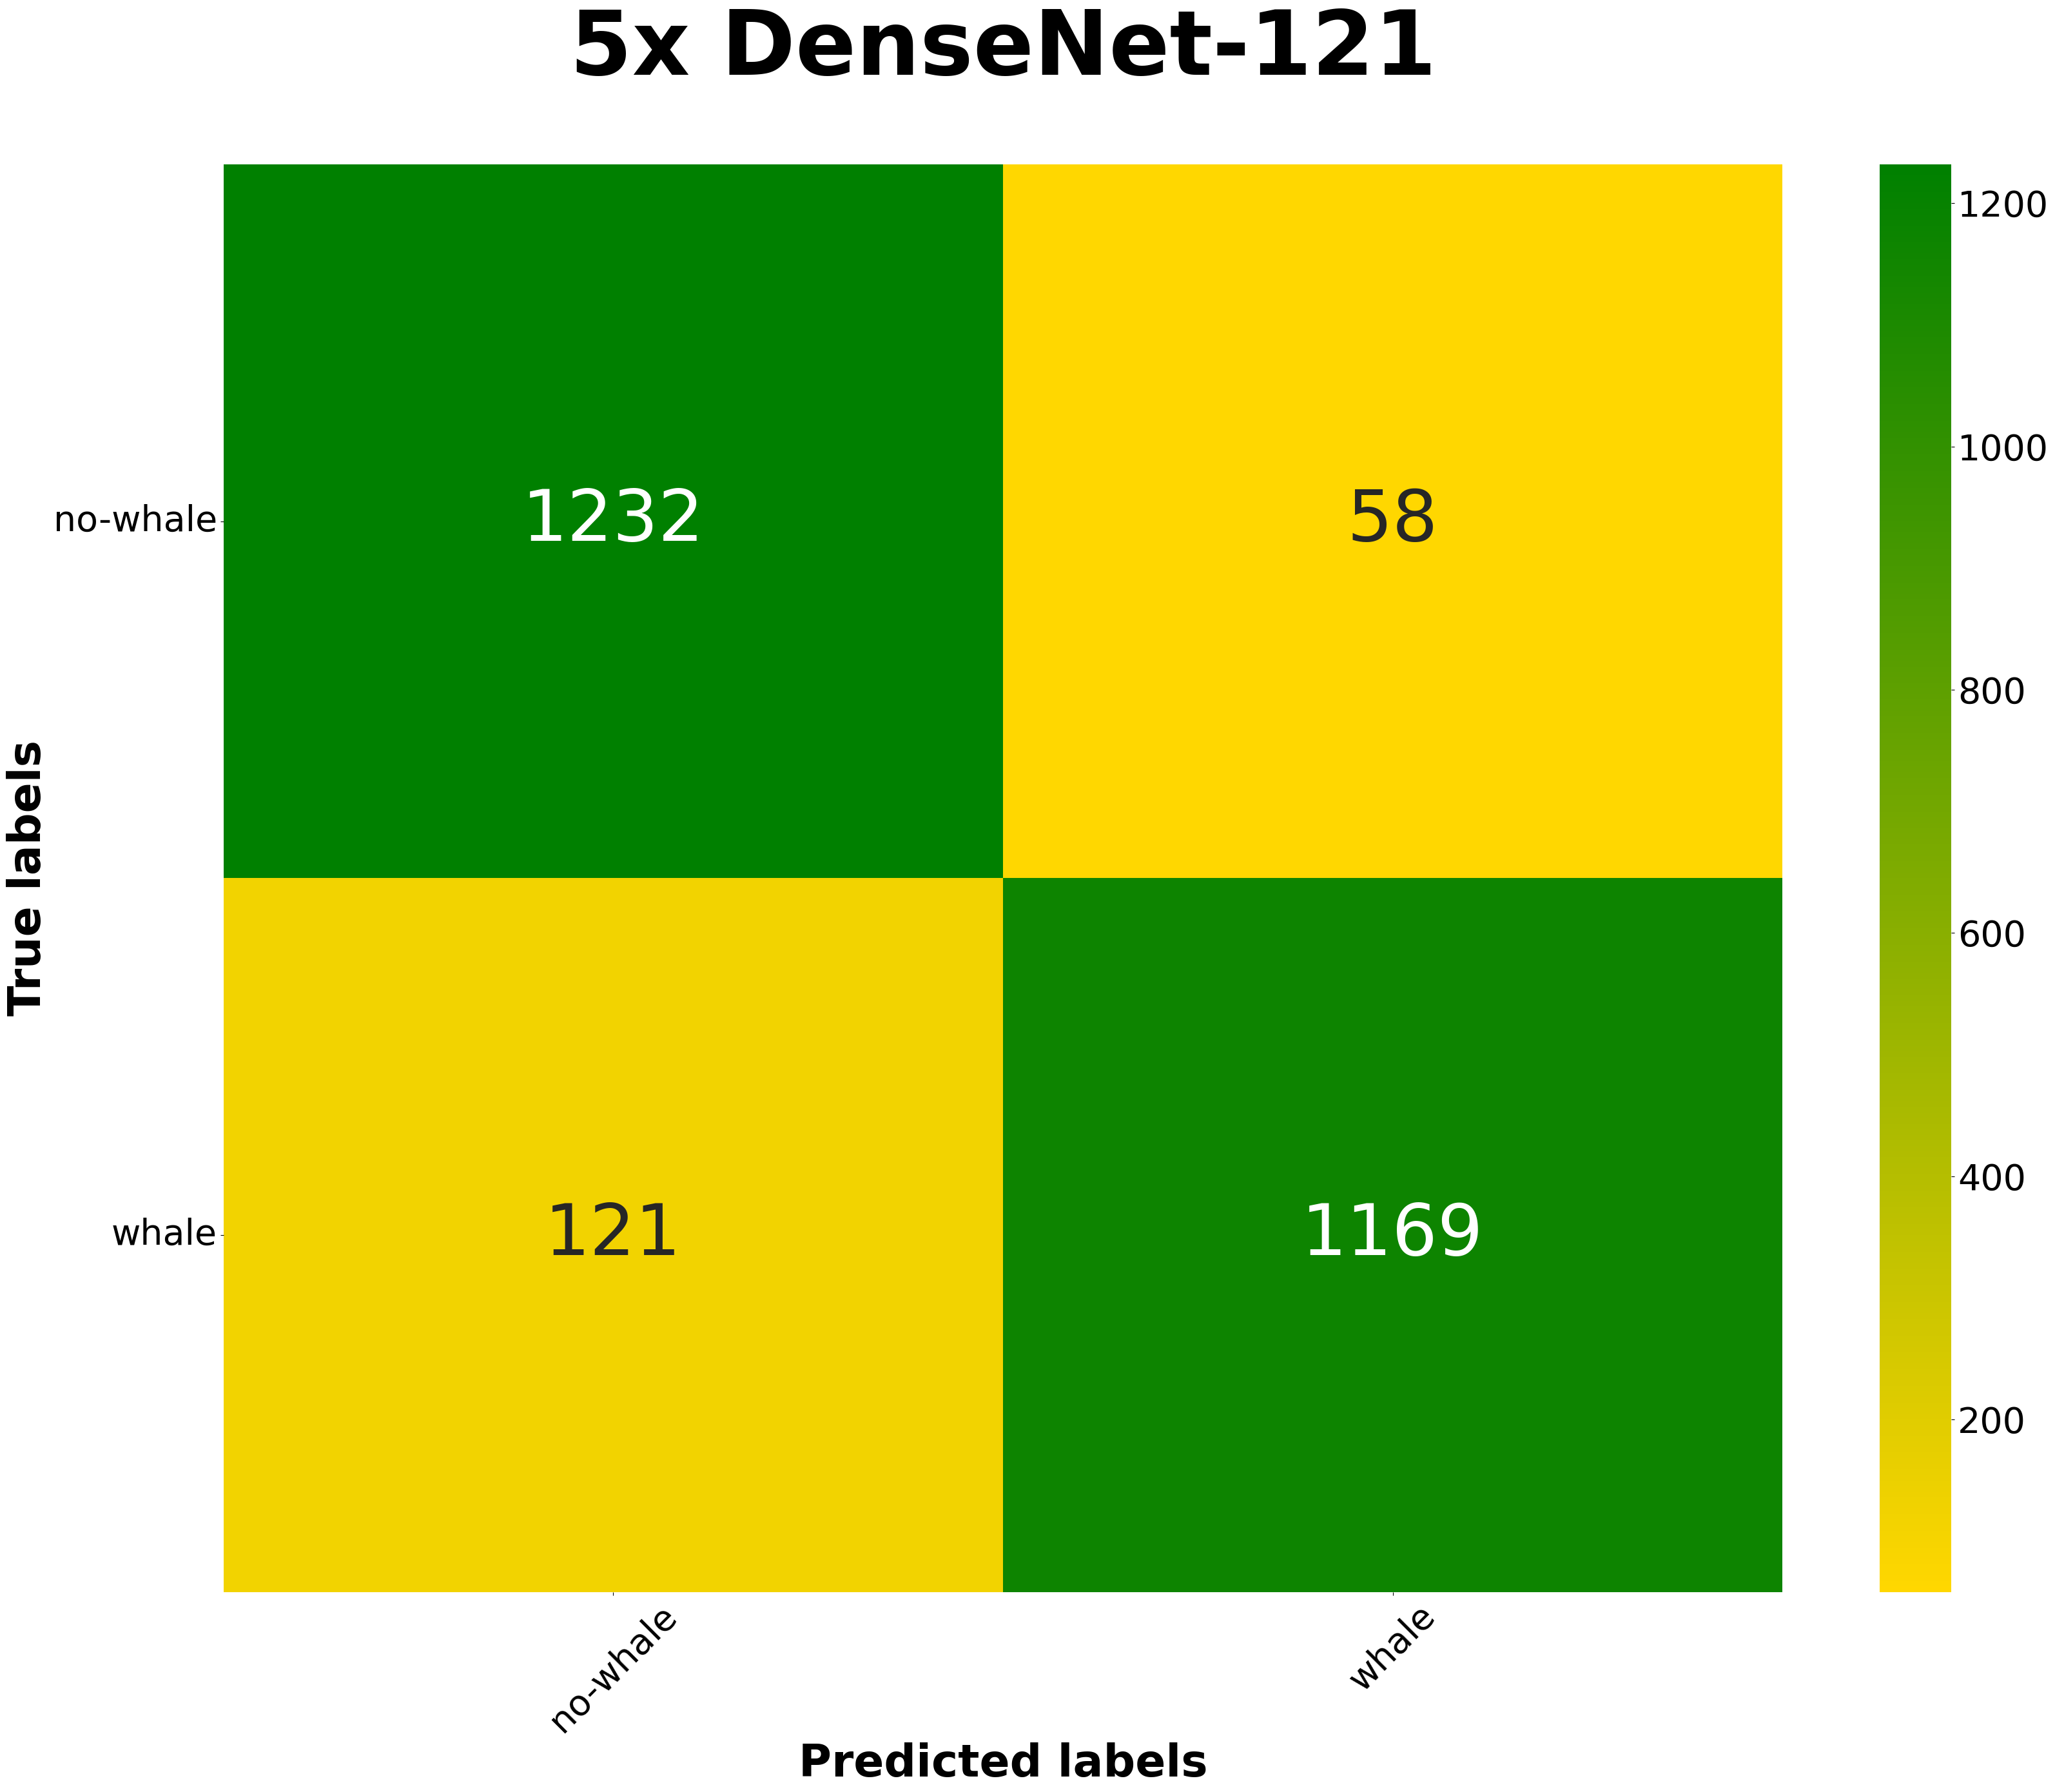

In [21]:
cm = confusion_matrix(data_test_labels, final_predictions_test, labels=list(range(len(target_names))))

SMALL_SIZE = 80
MEDIUM_SIZE = 40
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=0)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=0)  # legend fontsize
plt.rc('figure', titlesize=0)  # fontsize of the figure title

# Create a custom colormap from gold to green
gold_green_cmap = LinearSegmentedColormap.from_list("gold_green", ["gold", "green"])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(36,30))
sns.heatmap(cm, annot=True, fmt='g', cmap=gold_green_cmap, ax=ax)  # Use the custom colormap

# Set axis labels and titles with bold weight and adjusted fontsize
ax.set_xlabel('Predicted labels', weight="bold", fontsize=50)
ax.set_ylabel('True labels', weight="bold", fontsize=50)
tick_marks_x = np.arange(len(target_names)) + 0.5
tick_marks_y = np.arange(len(target_names)) + 0.5

# Set tick labels
plt.xticks(tick_marks_x, target_names, rotation=45, fontsize=40)
plt.yticks(tick_marks_y, target_names, rotation=0, fontsize=40)

# Set plot title
plt.title(f"5x DenseNet-121",fontsize=100,weight="bold",pad=100)
plt.tight_layout()  # Adjust layout to have space between the title and the figure

# Display the plot
plt.show()

# Save the figure
fig.savefig('cm_majority.svg', format='svg')

## Average voting

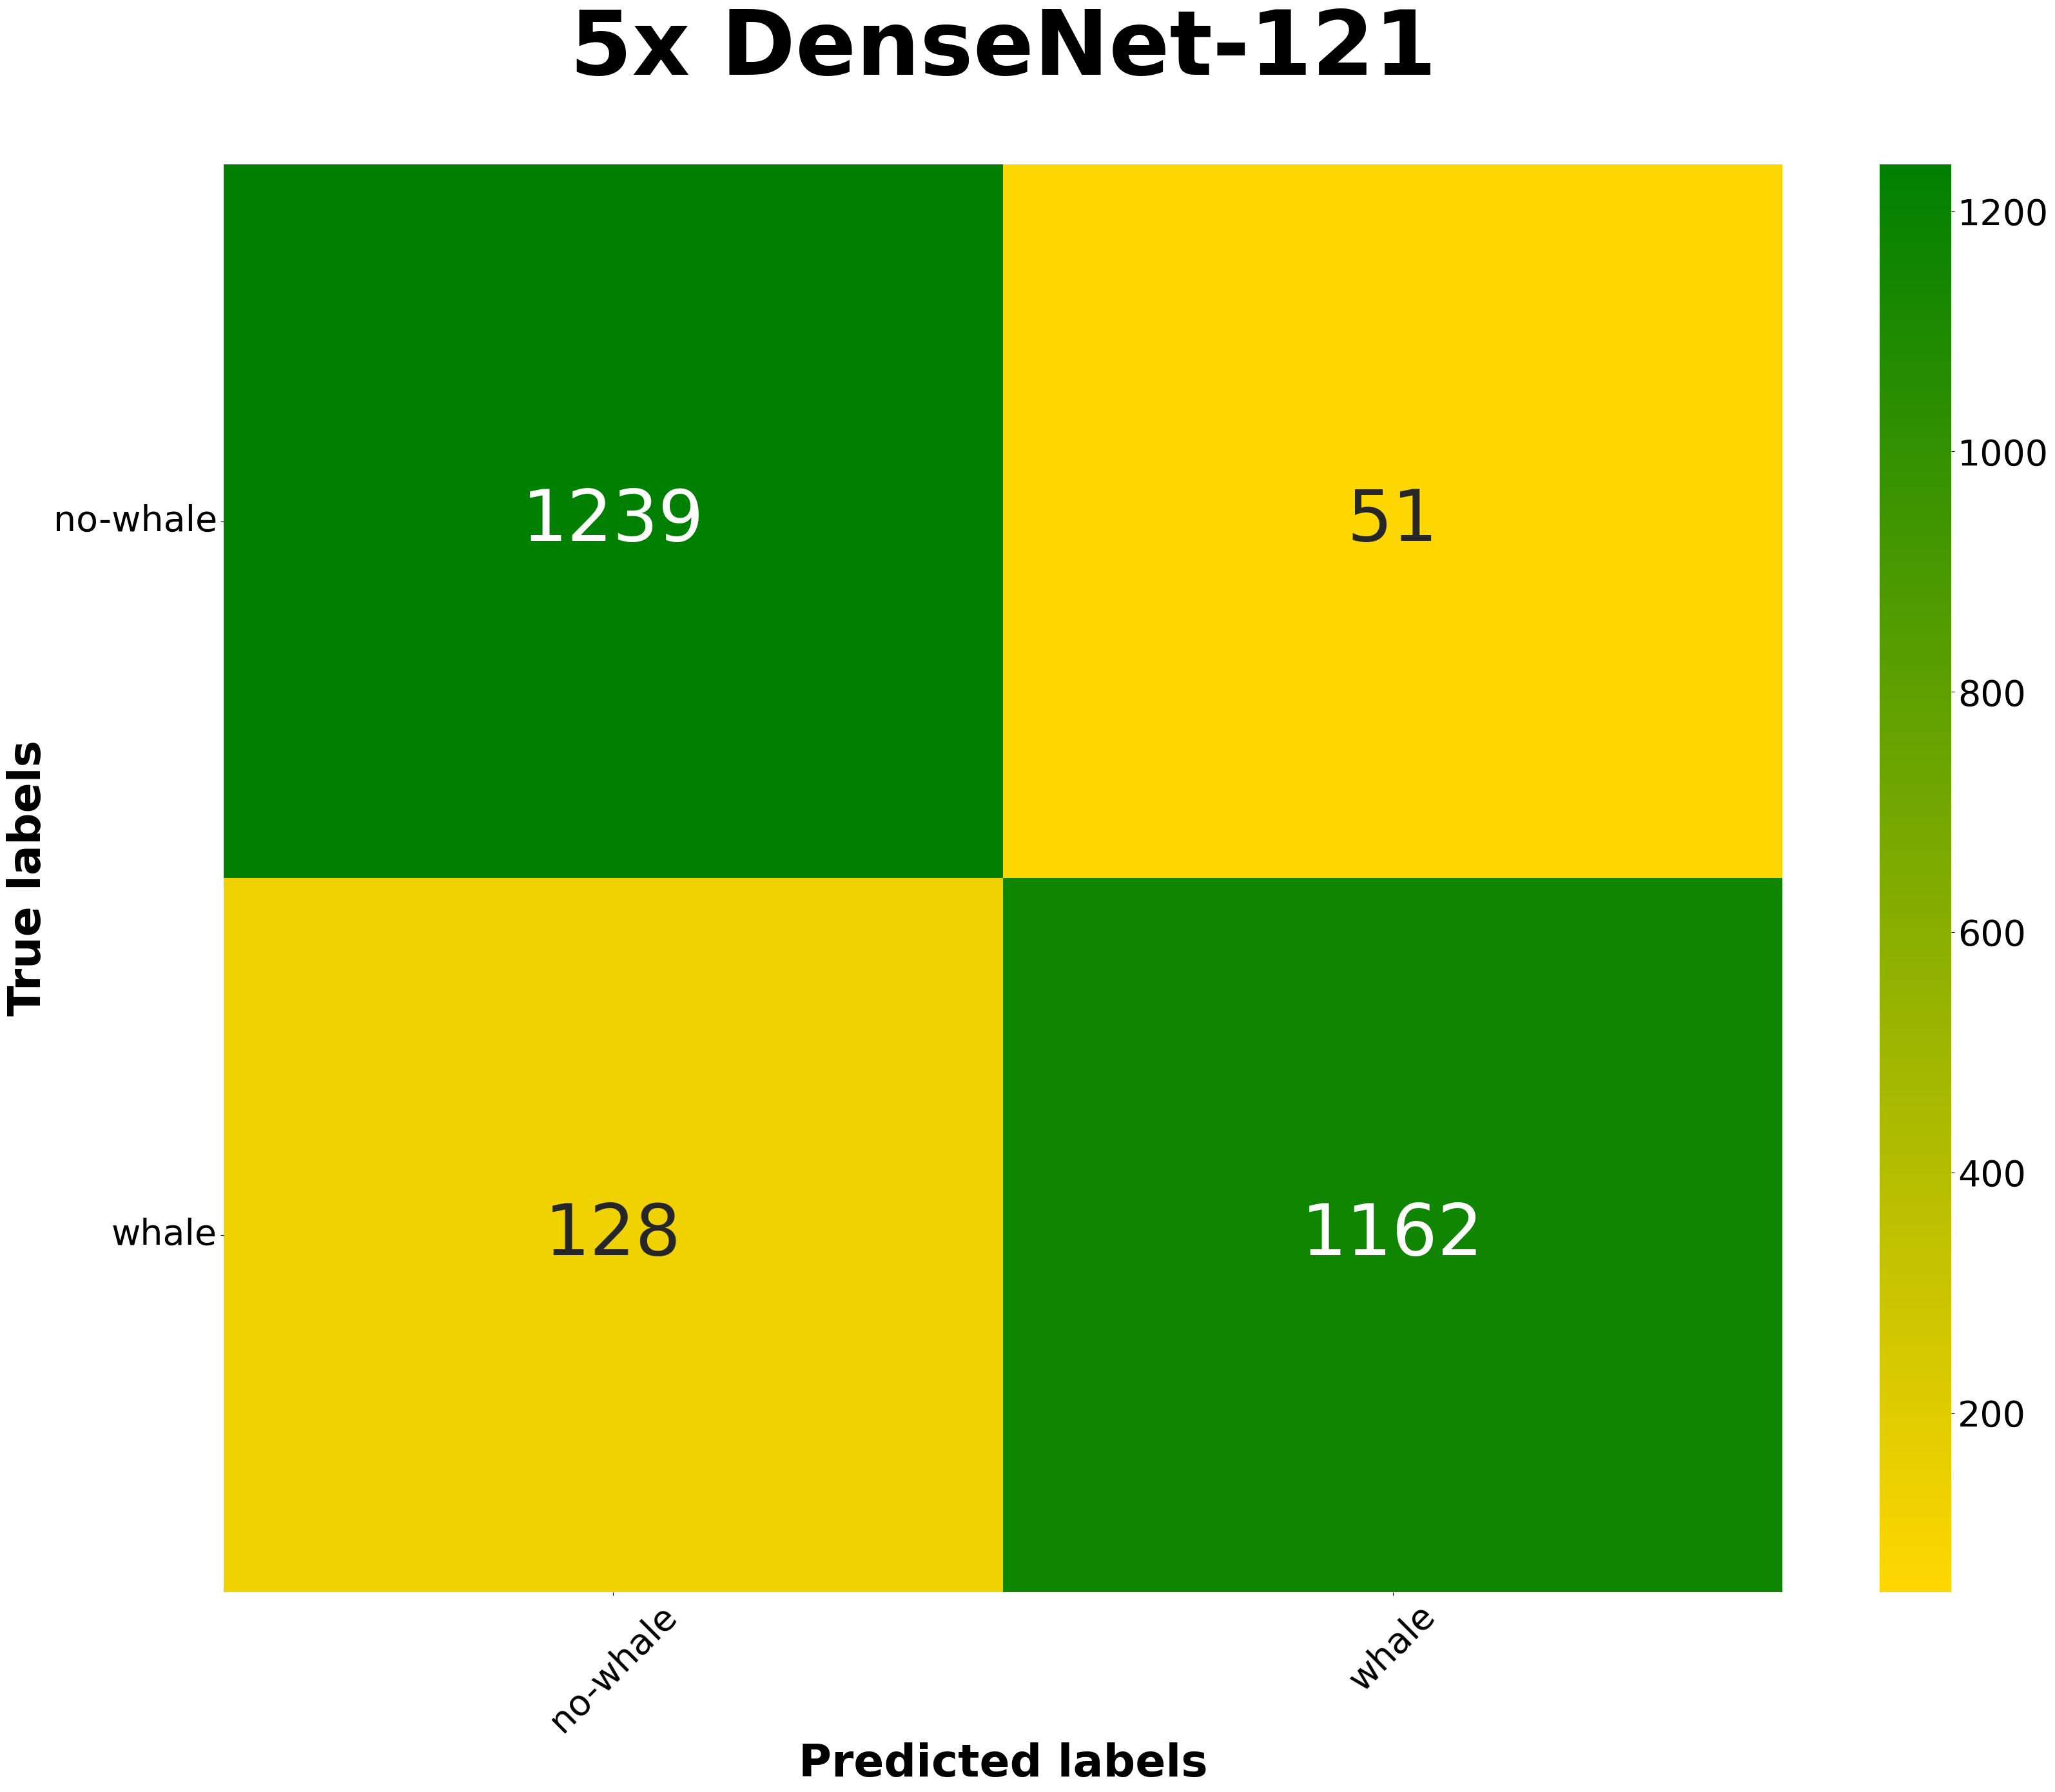

In [22]:
cm = confusion_matrix(data_test_labels, final_predictions_test_2, labels=list(range(len(target_names))))

SMALL_SIZE = 80
MEDIUM_SIZE = 40
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=0)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=0)  # legend fontsize
plt.rc('figure', titlesize=0)  # fontsize of the figure title

# Create a custom colormap from gold to green
gold_green_cmap = LinearSegmentedColormap.from_list("gold_green", ["gold", "green"])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(36,30))
sns.heatmap(cm, annot=True, fmt='g', cmap=gold_green_cmap, ax=ax)  # Use the custom colormap

# Set axis labels and titles with bold weight and adjusted fontsize
ax.set_xlabel('Predicted labels', weight="bold", fontsize=50)
ax.set_ylabel('True labels', weight="bold", fontsize=50)
tick_marks_x = np.arange(len(target_names)) + 0.5
tick_marks_y = np.arange(len(target_names)) + 0.5

# Set tick labels
plt.xticks(tick_marks_x, target_names, rotation=45, fontsize=40)
plt.yticks(tick_marks_y, target_names, rotation=0, fontsize=40)

# Set plot title
plt.title(f"5x DenseNet-121",fontsize=100,weight="bold",pad=100)
plt.tight_layout()  # Adjust layout to have space between the title and the figure

# Display the plot
plt.show()

# Save the figure
fig.savefig('cm_average.svg', format='svg')